In [1]:
import os
import glob
import cv2 as cv
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from scipy.linalg import fractional_matrix_power
from skimage.filters import threshold_otsu, threshold_local

In [93]:
# import internal packages
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from predict import (load_needlenet, microneedle_array_from_raw_image)
from binnet import load_binnet

In [91]:
def imbbox(im, intensity_threshold, im_filter_size = 0, MAXB=256, idx_threshold_min=2, idx_threshold_max=255, bin_filter_size=0, bboxmag=1.0, bboxcolor = (255,0,0), dst_siz=(360,360), bin_morph_size=0, crop_boundary=False, outlier_removal=False):
    if crop_boundary:
        [H, W] = im.shape
        im = im[H//8:-H//8,W//8:-W//8]
    if im_filter_size > 0:
        im_filter = cv.medianBlur(im, im_filter_size)
    else:
        im_filter = im.copy()
    hist, bin_edges = np.histogram(im_filter.ravel(), MAXB, [0,MAXB])

    revsum = np.cumsum(hist[::-1])

    idx_threshold = MAXB - np.argwhere(revsum > intensity_threshold)[0] - 1
    idx_threshold = max(idx_threshold,idx_threshold_min)
    idx_threshold = min(idx_threshold,idx_threshold_max)

    im_bin = np.uint8((im_filter>=idx_threshold)*(MAXB-1))
    
    if bin_filter_size > 0:
        im_bin = cv.medianBlur(np.uint8(im_bin),bin_filter_size)
        
    if bin_morph_size > 0:
        # apply morphology
        morph_kernel = cv.getStructuringElement(
            cv.MORPH_ELLIPSE, (bin_morph_size, bin_morph_size))
        im_bin = cv.morphologyEx(im_bin, cv.MORPH_OPEN, morph_kernel)
        
    if outlier_removal:
        inlier_segmap1 = covariance_fitting(im_bin, 2)
        inlier_segmap = covariance_fitting(im_bin*inlier_segmap1, 2.5)
        im_bin = im_bin*inlier_segmap
    
    bin_size = [256, 256];
    im_bin = cv.resize(im_bin, bin_size)
    scale = np.array(im.shape) / np.array(bin_size); # [H,W] - [y,x]
    print(scale)
    coords = np.column_stack(np.where(im_bin>MAXB/2))[:,[1,0]]

    im_box = im.copy()
    rect = cv.minAreaRect(coords)
    box_bin = cv.boxPoints(rect)
    
    im_box_bin = im_bin.copy()
    plt.figure(dpi=150)
    plt.imshow(cv.drawContours(im_box_bin,[np.int0(box_bin)],0,bboxcolor,2),cmap='gray')
    
    print(box_bin * scale[[1,0]])
    box = np.int0(np.round(box_bin * scale[[1,0]]))
    plt.figure(dpi=150)
    plt.imshow(cv.drawContours(im_box,[box],0,bboxcolor,2), cmap='gray')
    print(box)
    rect = cv.minAreaRect(box)
    
    size_new = tuple(l*bboxmag for l in rect[1])
    rect = (rect[0],size_new,rect[2])
    
    im_crop, _ = crop_rect(im, rect)
    if im_crop is not None:
        im_crop = cv.resize(cv.rotate(im_crop,2),dst_size)
    
    box = cv.boxPoints(rect)
    box = np.int0(box)
    cv.drawContours(im_box,[box],0,bboxcolor,2)
    for ib in range(box.shape[0]):
        cv.circle(im_box, box[ib], radius=10, color=(255, 0, 255), thickness=3)
    
    return im_crop, im_box, im_bin, idx_threshold

def crop_rect(img, rect):
    # get the parameter of the small rectangle
    center, size, angle = rect[0], rect[1], rect[2]
    center, size = tuple(map(int, center)), tuple(map(int, size))

    # get row and col num in img
    height, width = img.shape[0], img.shape[1]

    # calculate the rotation matrix
    M = cv.getRotationMatrix2D(center, angle, 1)
    # rotate the original image
    img_rot = cv.warpAffine(img, M, (width, height), borderMode=cv.BORDER_REPLICATE)

    # now rotated rectangle becomes vertical, and we crop it
    img_crop = cv.getRectSubPix(img_rot, size, center)

    return img_crop, img_rot

def covariance_fitting(im, variance_range=2):
    [H, W] = im.shape
    xx, yy = np.meshgrid(np.linspace(0, W, W), np.linspace(0, H, H))

    X = np.stack(np.where(im>0),axis=0)
    cov_mat = np.cov(X)

    sigma_inv = fractional_matrix_power(cov_mat, -0.5)

    z0 = np.average(X, axis=1)
    z  = np.stack([yy.flatten(), xx.flatten()], axis=1)
    dz = z - z0
    z_norm = dz @ sigma_inv
    
    inlier_seg = np.amax(np.abs(z_norm), axis=1) <= variance_range

    inlier_segmap = inlier_seg.reshape([H,W])
    
    return inlier_segmap

In [ ]:
MAXB = 256
intensity_threshold = 60*15*15
idx_threshold_min = 2
idx_threshold_max = MAXB-1
bboxmag = 1.35         # magnification factor of the bounding box
bboxcolor = (255,0,0) # color of the bounding box
im_filter_size = 5
bin_filter_size = 5
# dst_size = (360,360)
dst_size = (120,120)

# imdir = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Day_0_train_set'
# imdir = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Images'
imdir = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Images0706'

imresultdir = imdir + '/binarization'
# imcropdir = imdir + '/cropped'
imcropdir = imdir + '/cropped_120x120'
Path(imresultdir).mkdir(parents=True, exist_ok=True)
Path(imcropdir).mkdir(parents=True, exist_ok=True)

imfilelist = glob.glob(imdir + '/**/*.jpg', recursive=True)

for imfile in imfilelist:
    imresultfile = imresultdir + '/' + Path(imfile).stem + '.jpg'
    imcropfile = imcropdir + '/' + Path(imfile).stem + '_crop.jpg'
    
    im = cv.imread(imfile, 0)
    # im = cv.imread(imfile)
    # im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    
    im_crop, im_box, im_bin, idx_threshold = imbbox(im, intensity_threshold, 0, MAXB, idx_threshold_min, idx_threshold_max, 0, bboxmag, bboxcolor, dst_size)

    im_crop_f, im_box_f, im_bin_f, idx_threshold_f = imbbox(im, intensity_threshold, im_filter_size, MAXB, idx_threshold_min, idx_threshold_max, bin_filter_size, bboxmag, bboxcolor, dst_size)
    
    if im_crop_f is not None:
        cv.imwrite(imcropfile, im_crop_f)
        
        fig = plt.figure(figsize=[10,12.5],dpi=300)
        plt.subplot(321)
        plt.imshow(im)
        plt.title('original image')
        plt.subplot(322)
        # plt.hist(im.ravel(),MAXB,[0,MAXB])
        # plt.title('histogram of the original image')
        plt.imshow(im_crop_f)
        plt.title('final cropped image')
        plt.subplot(323)
        plt.imshow(im_bin)
        plt.title('image after global thresholding (%d of %d)' % (idx_threshold, MAXB))
        plt.subplot(324)
        plt.imshow(im_box)
        plt.title('image with bounding box')
        plt.subplot(325)
        plt.imshow(im_bin_f)
        plt.title('filtered image after thresholding (%d of %d)' % (idx_threshold_f, MAXB))
        plt.subplot(326)
        plt.imshow(im_box_f)
        plt.title('filtered image with bounding box')
        plt.savefig(imresultfile,bbox_inches = 'tight',pad_inches = 0.2)
        # Clear the current axes.
        plt.cla() 
        # Clear the current figure.
        plt.clf() 
        # Closes all the figure windows.
        plt.close('all')
        plt.close(fig)
    else:
        print('No items identified in %s' % imfile)

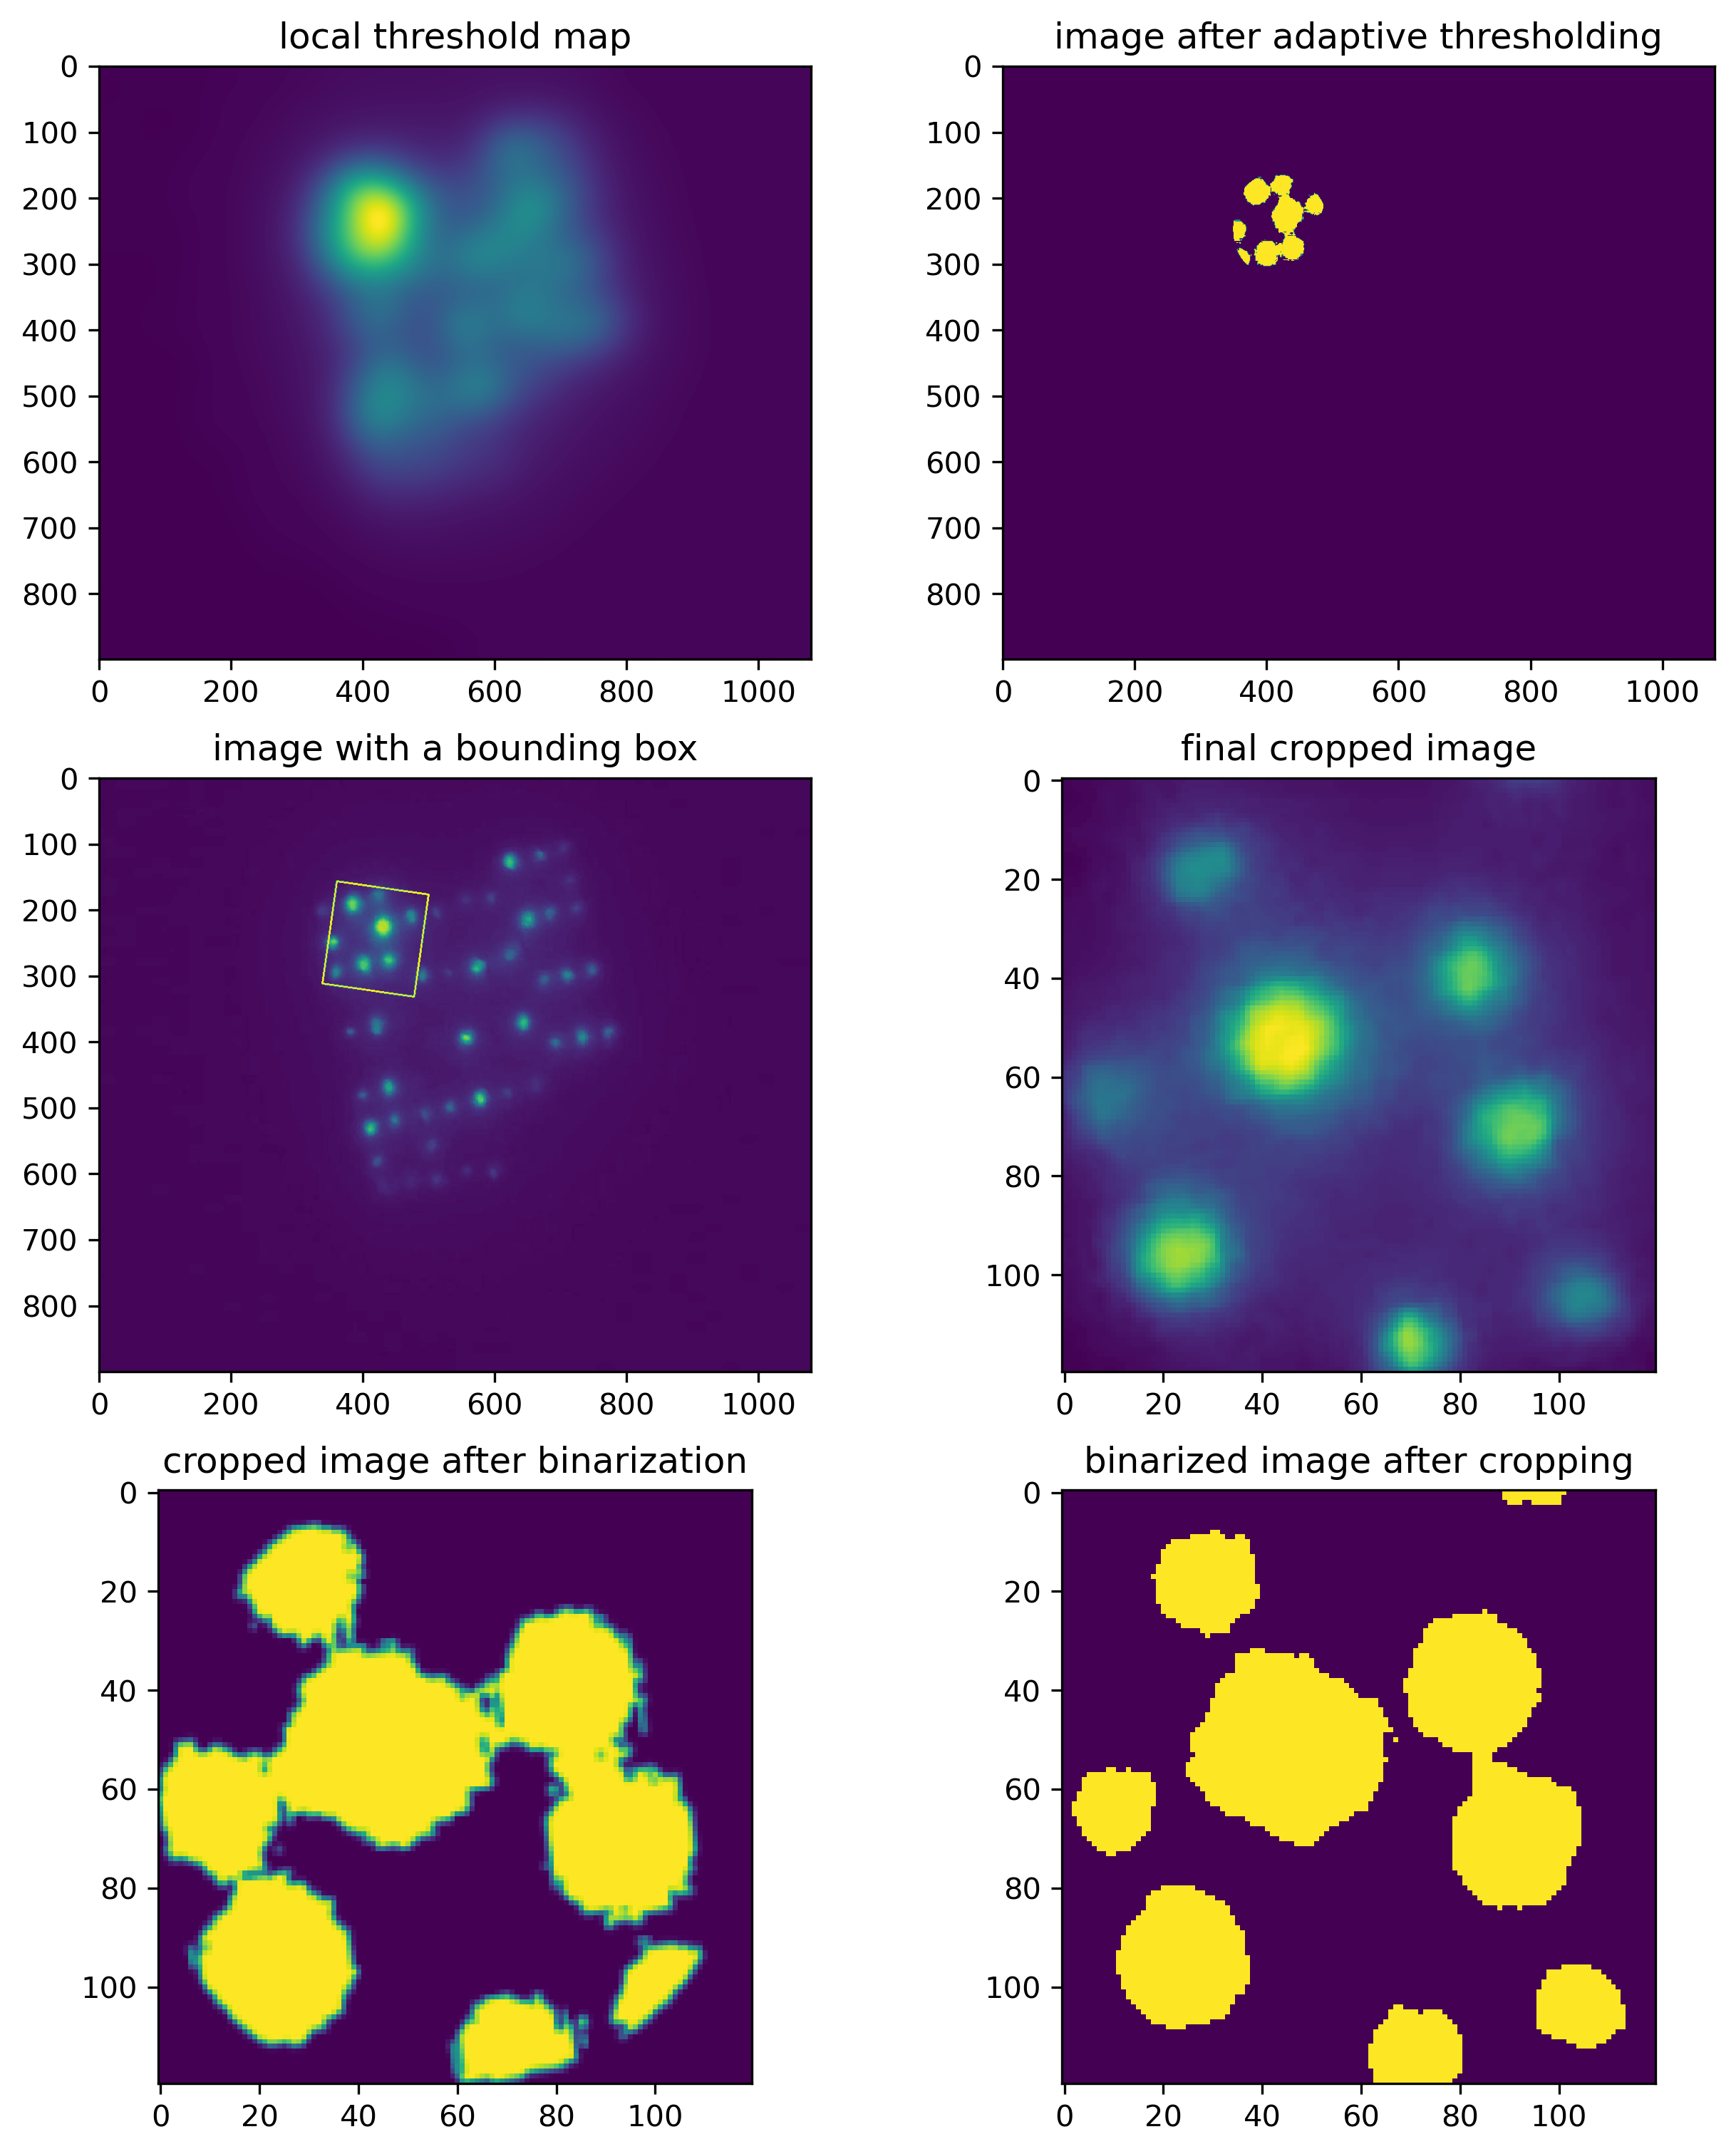

In [94]:
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Day_0_train_set/Gin.L.T.R.MP.16Ap.1.eth_17.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Day_0_train_set/Gin.right.TF.MP.Ap.22._8.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Day_0_train_set/Gin.left.newapp.7Jun21_9.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Day_0_train_set/LI.right4.A2.cone.28June21_4.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Day_0_train_set/Kho.Left.BR.Oct26_5.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Day_0_train_set/Kho.Left.BR.Oct26_8.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Images/Day 6/BF_Pattern3_Con/LI.right.BF.15Jun21_1.jpg'

# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Images0706/LI_New Applicator/BF_Pattern5_Pyr/LI.L.BF.Jul6_19.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Images0706/LI_New Applicator/BF_Pattern5_Pyr/LI.L.BF.Jul6_20.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Images0706/LI_New Applicator/BR_Pattern6_Pyr/LI.L.BR.Jul6_7.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Images0706/LI_New Applicator/TF_Pattern6_Con/LI.L.TF.Jul6_1.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Images0706/LI_New Applicator/TF_Pattern6_Con/LI.L.TF.Jul6_3.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Images0706/LI_New Applicator/Day 0/TF_Pattern6_Con/LI.L.TF.Jul6_4.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Images0706/LI_New Applicator/TF_Pattern6_Con/LI.L.TF.Jul6_25.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Images0706/LI_New Applicator/TF_Pattern6_Con/LI.L.TF.Jul6_27.jpg'
# imfile = '/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/microneedle/data/Images0706/LI/Day 19/TF_Pattern4_Con/LI.right.TF.28June21_10.jpg'

# imfile = "/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/Jooli's/12x12 Pattern/12 x12_400um_1mm_App3/Day 8 -08.31.2021/Rum_L_TF_Pattern11/Rum.L.TF.Aug31.2021_29.jpg"

# # wrong rectification because of low histogram threshold [fixed needle_size*needle_size*0.7*15*15 -> 0.8*20*20]
# imfile = "/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/Jooli's/pattern_new code/Fail cases/_Pattern3/Dara- 3B- day 52/Dara.R.3B.jan21.2022_26.jpg"

# super high background noise - crop the high noise part
# imfile = "/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/Jooli's/Fail cases/Pig_Pattern_10x10/_Pattern4/LI-MP TF 4-day 64/LI.R.TF.august12.2021_12.jpg"
# imfile = "/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/Jooli's/Fail cases/Pig_Pattern_10x10/_Pattern4/LI-MP TF 4-day 64/LI.R.TF.august12.2021_17.jpg"
imfile = "/data/yliu/docs/Dropbox (MIT)/proj/microneedle/code/test_images/Dara.R.3B.jan21.2022_4_rz.jpg"

# super dim boundary and corner dots
# imfile = "/data/yliu/docs/Dropbox (MIT)/Vaccine_Tracking2/Real Images/Real Images/Jooli's/pattern_new code/Fail cases/_Pattern5/Dara- 5A- day 52/Dara.R.5A.jan21.2022_16.jpg"

# imresultdir = imdir + '/binarization'
# imresultfile = imresultdir + '/' + Path(imfile).stem + '.jpg'
# imcropfile = imcropdir + '/' + Path(imfile).stem + '_crop.jpg'

MAXB = 256
needle_size = 10
# intensity_threshold = 100*30*30
# intensity_threshold = 60*15*15
# intensity_threshold = needle_size*needle_size*0.7*15*15
intensity_threshold = needle_size*needle_size*0.8*20*20
idx_threshold_min = 2
idx_threshold_max = MAXB-1
bboxmag = 1.35         # magnification factor of the bounding box
bboxcolor = (255,0,0) # color of the bounding box
im_filter_size = 5
bin_filter_size = 5
# dst_size = (360,360)
dst_size = (120,120)

bin_morph_size = 7
crop_boundary = False

im = cv.imread(imfile, 0)

# im = cv.equalizeHist(im)
# im_filter = cv.medianBlur(im,im_filter_size)
im_adpthresh = cv.adaptiveThreshold(im,1,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,201,0)

block_size = 201
p_max = 0.5
local_thresh = threshold_local(im, block_size)
binary_local = im > local_thresh
T_bg = local_thresh <= (1-p_max)*local_thresh.min() + p_max*local_thresh.max()
# im[T_bg] = 0
binary_local[T_bg] = 0

im_box = im.copy()
coords = np.column_stack(np.where(1-T_bg))[:,[1,0]]
rect = cv.minAreaRect(coords)    
box = cv.boxPoints(rect)
box = np.int0(box)
cv.drawContours(im_box,[box],0,bboxcolor,2)

im_crop, _ = crop_rect(im, rect)
im_crop = cv.resize(cv.rotate(im_crop,2),dst_size)
imbin_crop, _ = crop_rect(np.uint8(binary_local*(MAXB-1)),rect)
imbin_crop = cv.resize(cv.rotate(imbin_crop,2),dst_size)

local_thresh_crop = threshold_local(im_crop, block_size=151)
im_crop_bin = im_crop > local_thresh_crop

plt.figure(figsize=[10,12.5],dpi=300)
plt.subplot(321)
plt.imshow(local_thresh)
plt.title('local threshold map')
plt.subplot(322)
plt.imshow(binary_local)
plt.title('image after adaptive thresholding')
plt.subplot(323)
plt.imshow(im_box)
plt.title('image with a bounding box')
plt.subplot(324)
plt.imshow(im_crop)
plt.title('final cropped image')
plt.subplot(325)
plt.imshow(imbin_crop)
plt.title('cropped image after binarization')
plt.subplot(326)
plt.imshow(im_crop_bin)
plt.title('binarized image after cropping')
plt.show()

[3.515625 4.21875 ]
[[286.10500216 182.84865618]
 [694.87903118  94.53327656]
 [808.22137356 458.84774923]
 [399.44731236 547.16312885]]
[[286 183]
 [695  95]
 [808 459]
 [399 547]]
[3.515625 4.21875 ]
[[289.10848618 179.71048504]
 [697.08638191  94.7150901 ]
 [807.27019787 461.99451685]
 [399.29230213 546.98991179]]
[[289 180]
 [697  95]
 [807 462]
 [399 547]]


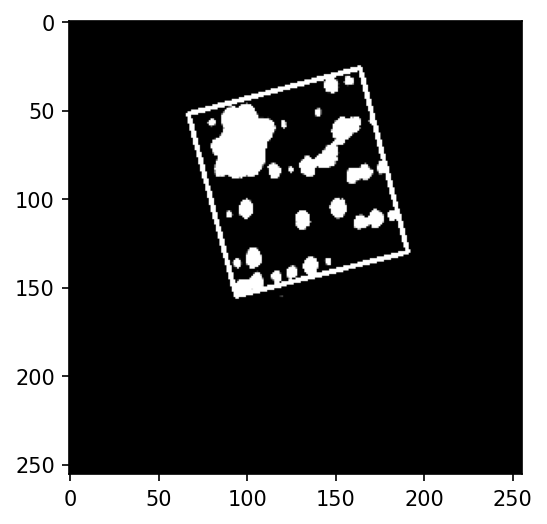

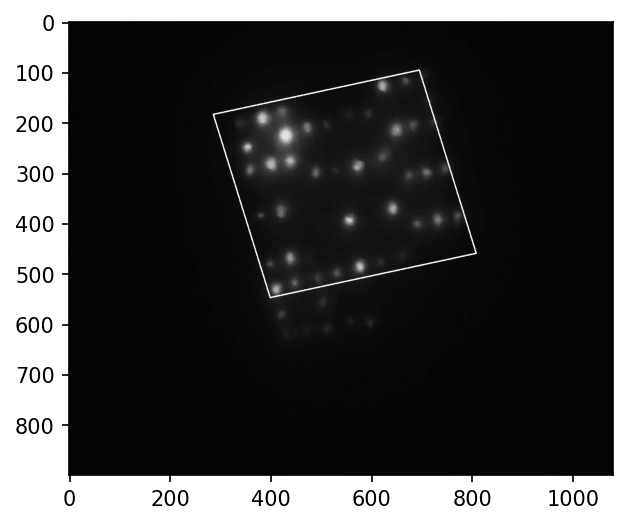

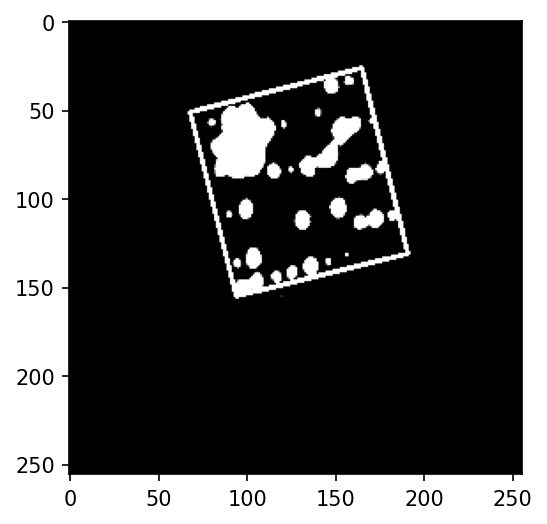

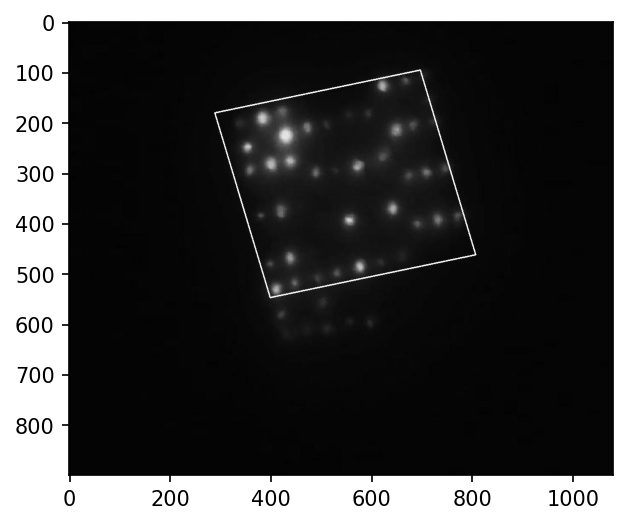

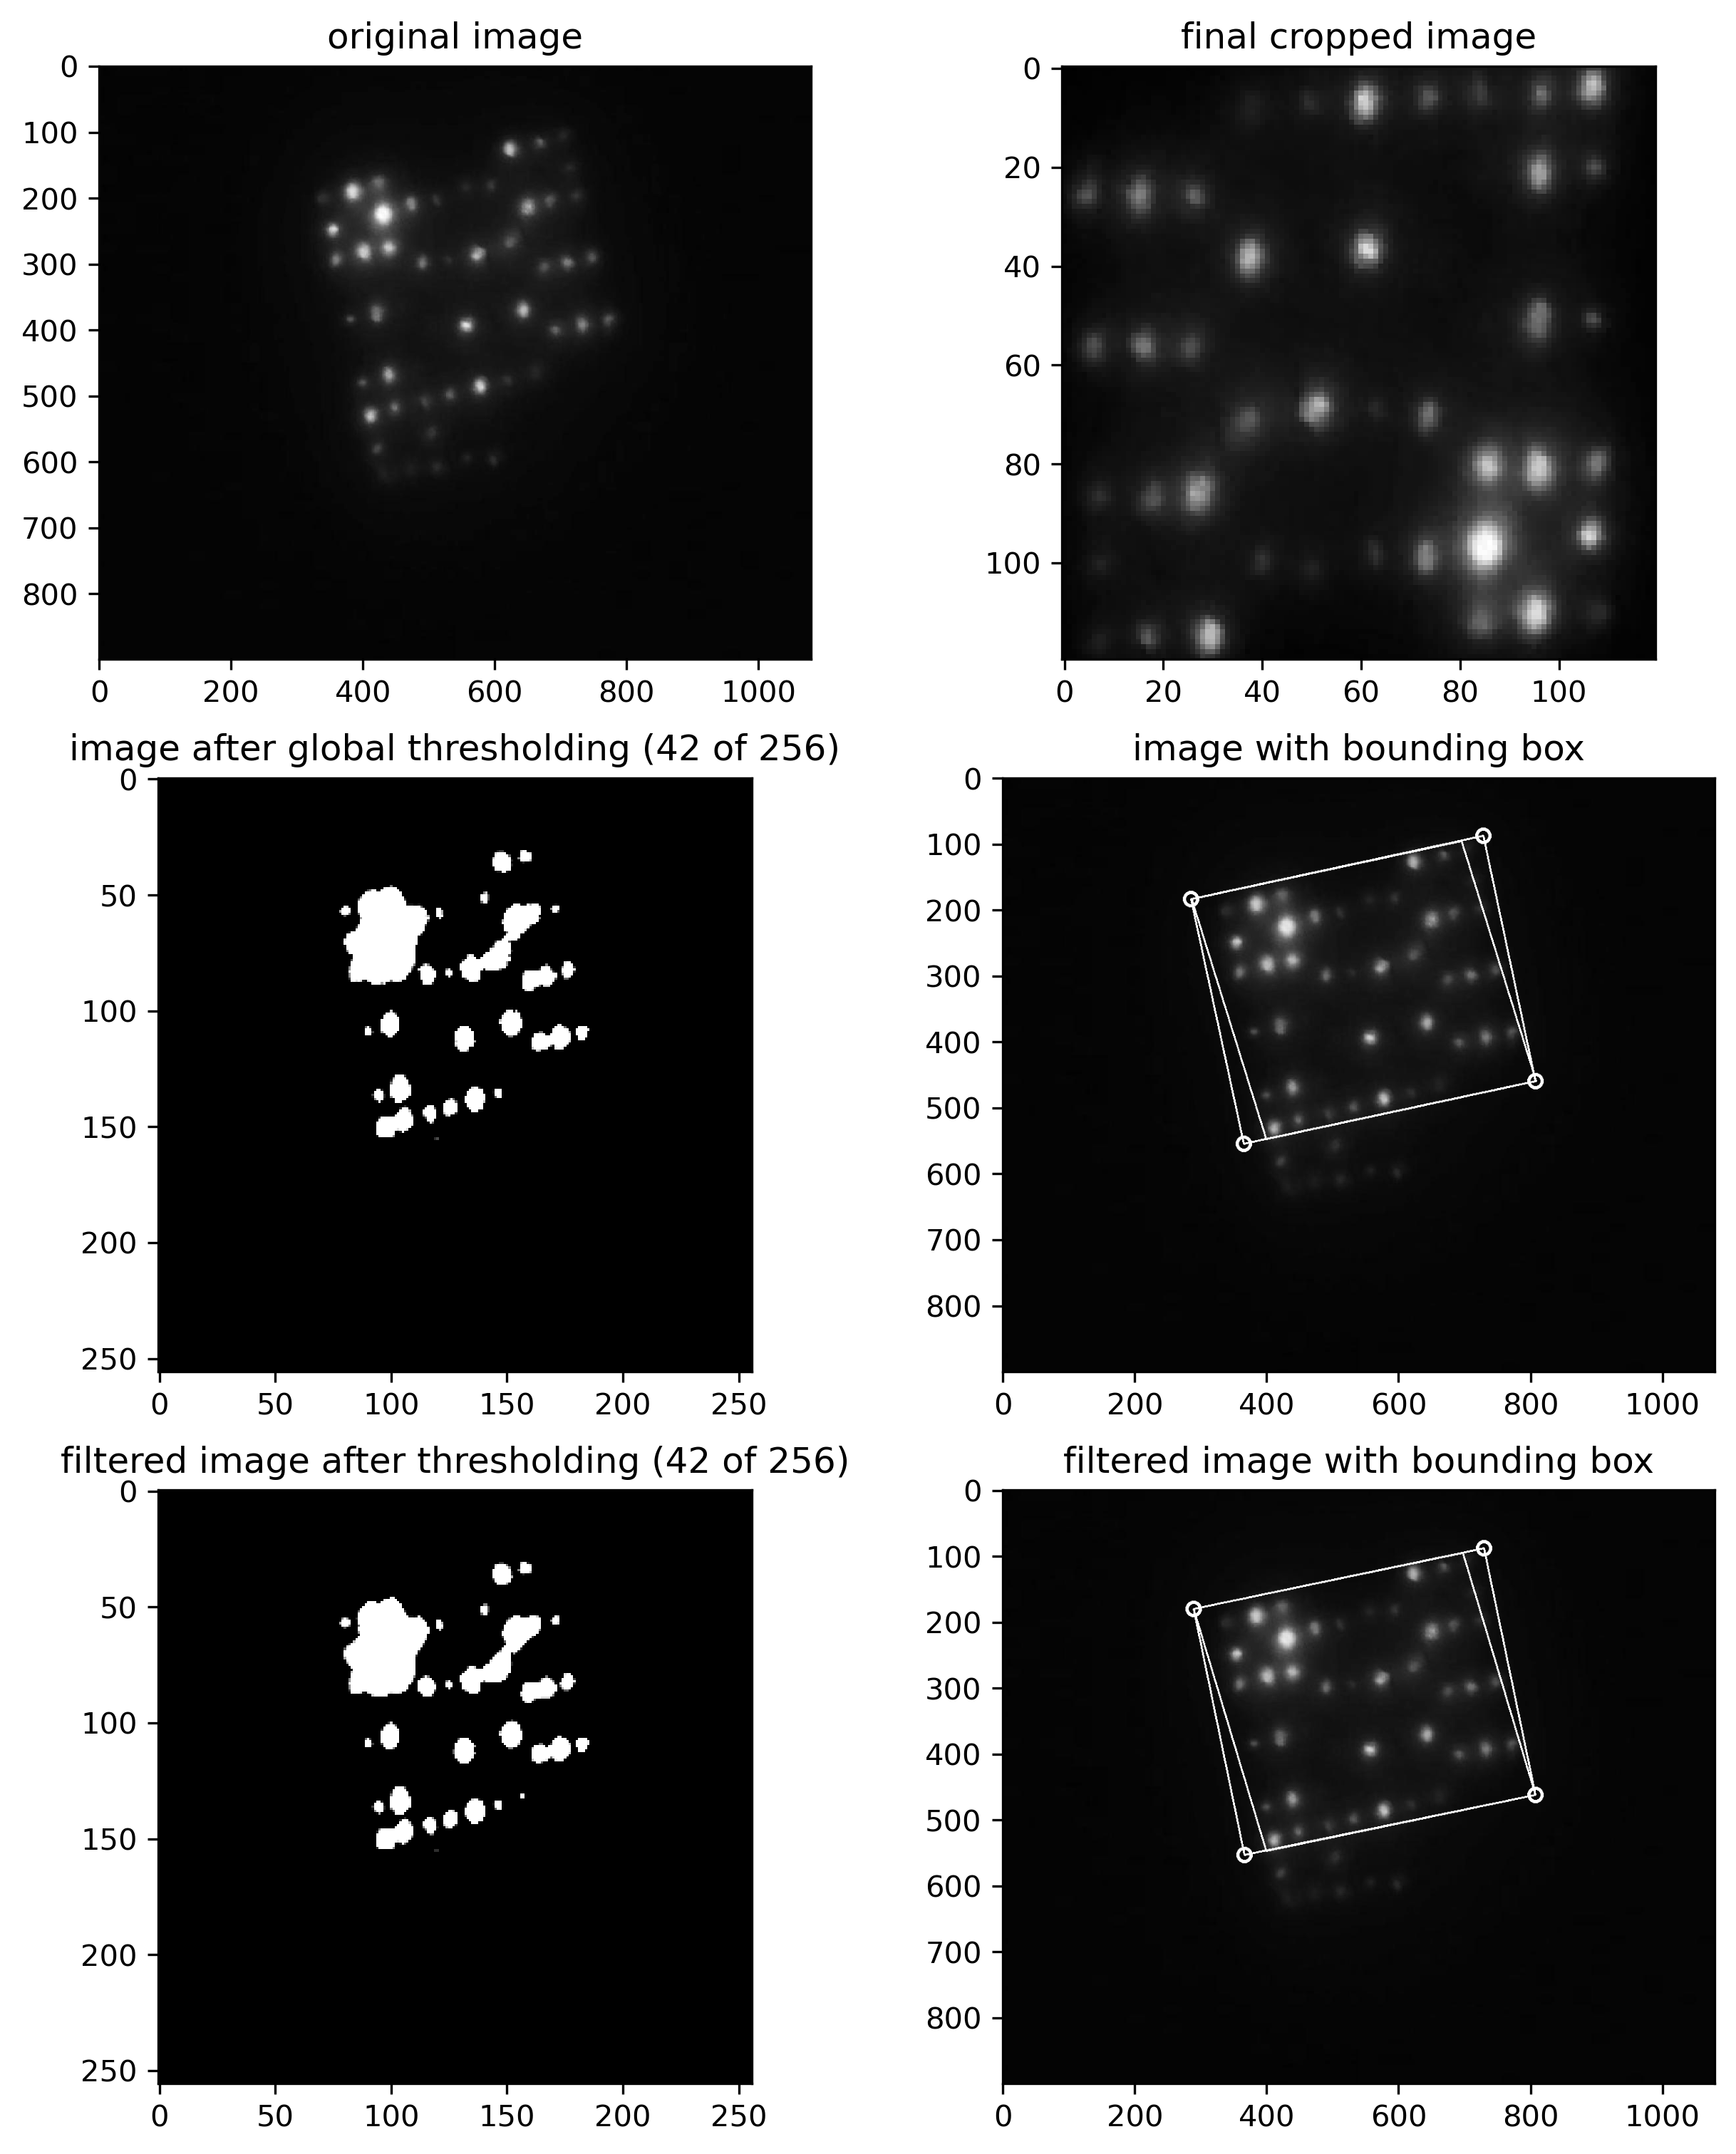

In [95]:
# bboxmag = 1.35         # magnification factor of the bounding box
bboxmag = 1         # magnification factor of the bounding box
intensity_threshold = needle_size*needle_size*1.0*20*20
# intensity_threshold = needle_size*needle_size*3.5*20*20
bin_morph_size = 9
crop_boundary = False
outlier_removal = True

im_crop, im_box, im_bin, idx_threshold = imbbox(im, intensity_threshold, 0, MAXB, idx_threshold_min, idx_threshold_max, 0, bboxmag, bboxcolor, dst_size, bin_morph_size, crop_boundary, outlier_removal)

im_crop_f, im_box_f, im_bin_f, idx_threshold_f = imbbox(im, intensity_threshold, im_filter_size, MAXB, idx_threshold_min, idx_threshold_max, bin_filter_size, bboxmag, bboxcolor, dst_size, bin_morph_size, crop_boundary, outlier_removal)

# if im_crop_f is not None:
#     cv.imwrite(imcropfile, im_crop_f)

fig = plt.figure(figsize=[10,12.5],dpi=300)
plt.subplot(321)
plt.imshow(im, cmap='gray')
plt.title('original image')
plt.subplot(322)
# plt.imshow(im_adpthresh)
# plt.title('image after adaptive thresholding')
# plt.hist(im.ravel(),MAXB,[0,MAXB])
# plt.title('histogram of the original image')
plt.imshow(im_crop_f, cmap='gray')
plt.title('final cropped image')
plt.subplot(323)
plt.imshow(im_bin, cmap='gray')
plt.title('image after global thresholding (%d of %d)' % (idx_threshold, MAXB))
plt.subplot(324)
plt.imshow(im_box, cmap='gray')
plt.title('image with bounding box')
plt.subplot(325)
plt.imshow(im_bin_f, cmap='gray')
plt.title('filtered image after thresholding (%d of %d)' % (idx_threshold_f, MAXB))
plt.subplot(326)
plt.imshow(im_box_f, cmap='gray')
plt.title('filtered image with bounding box')
# plt.savefig(imresultfile,bbox_inches = 'tight',pad_inches = 0.2)
plt.show(fig)

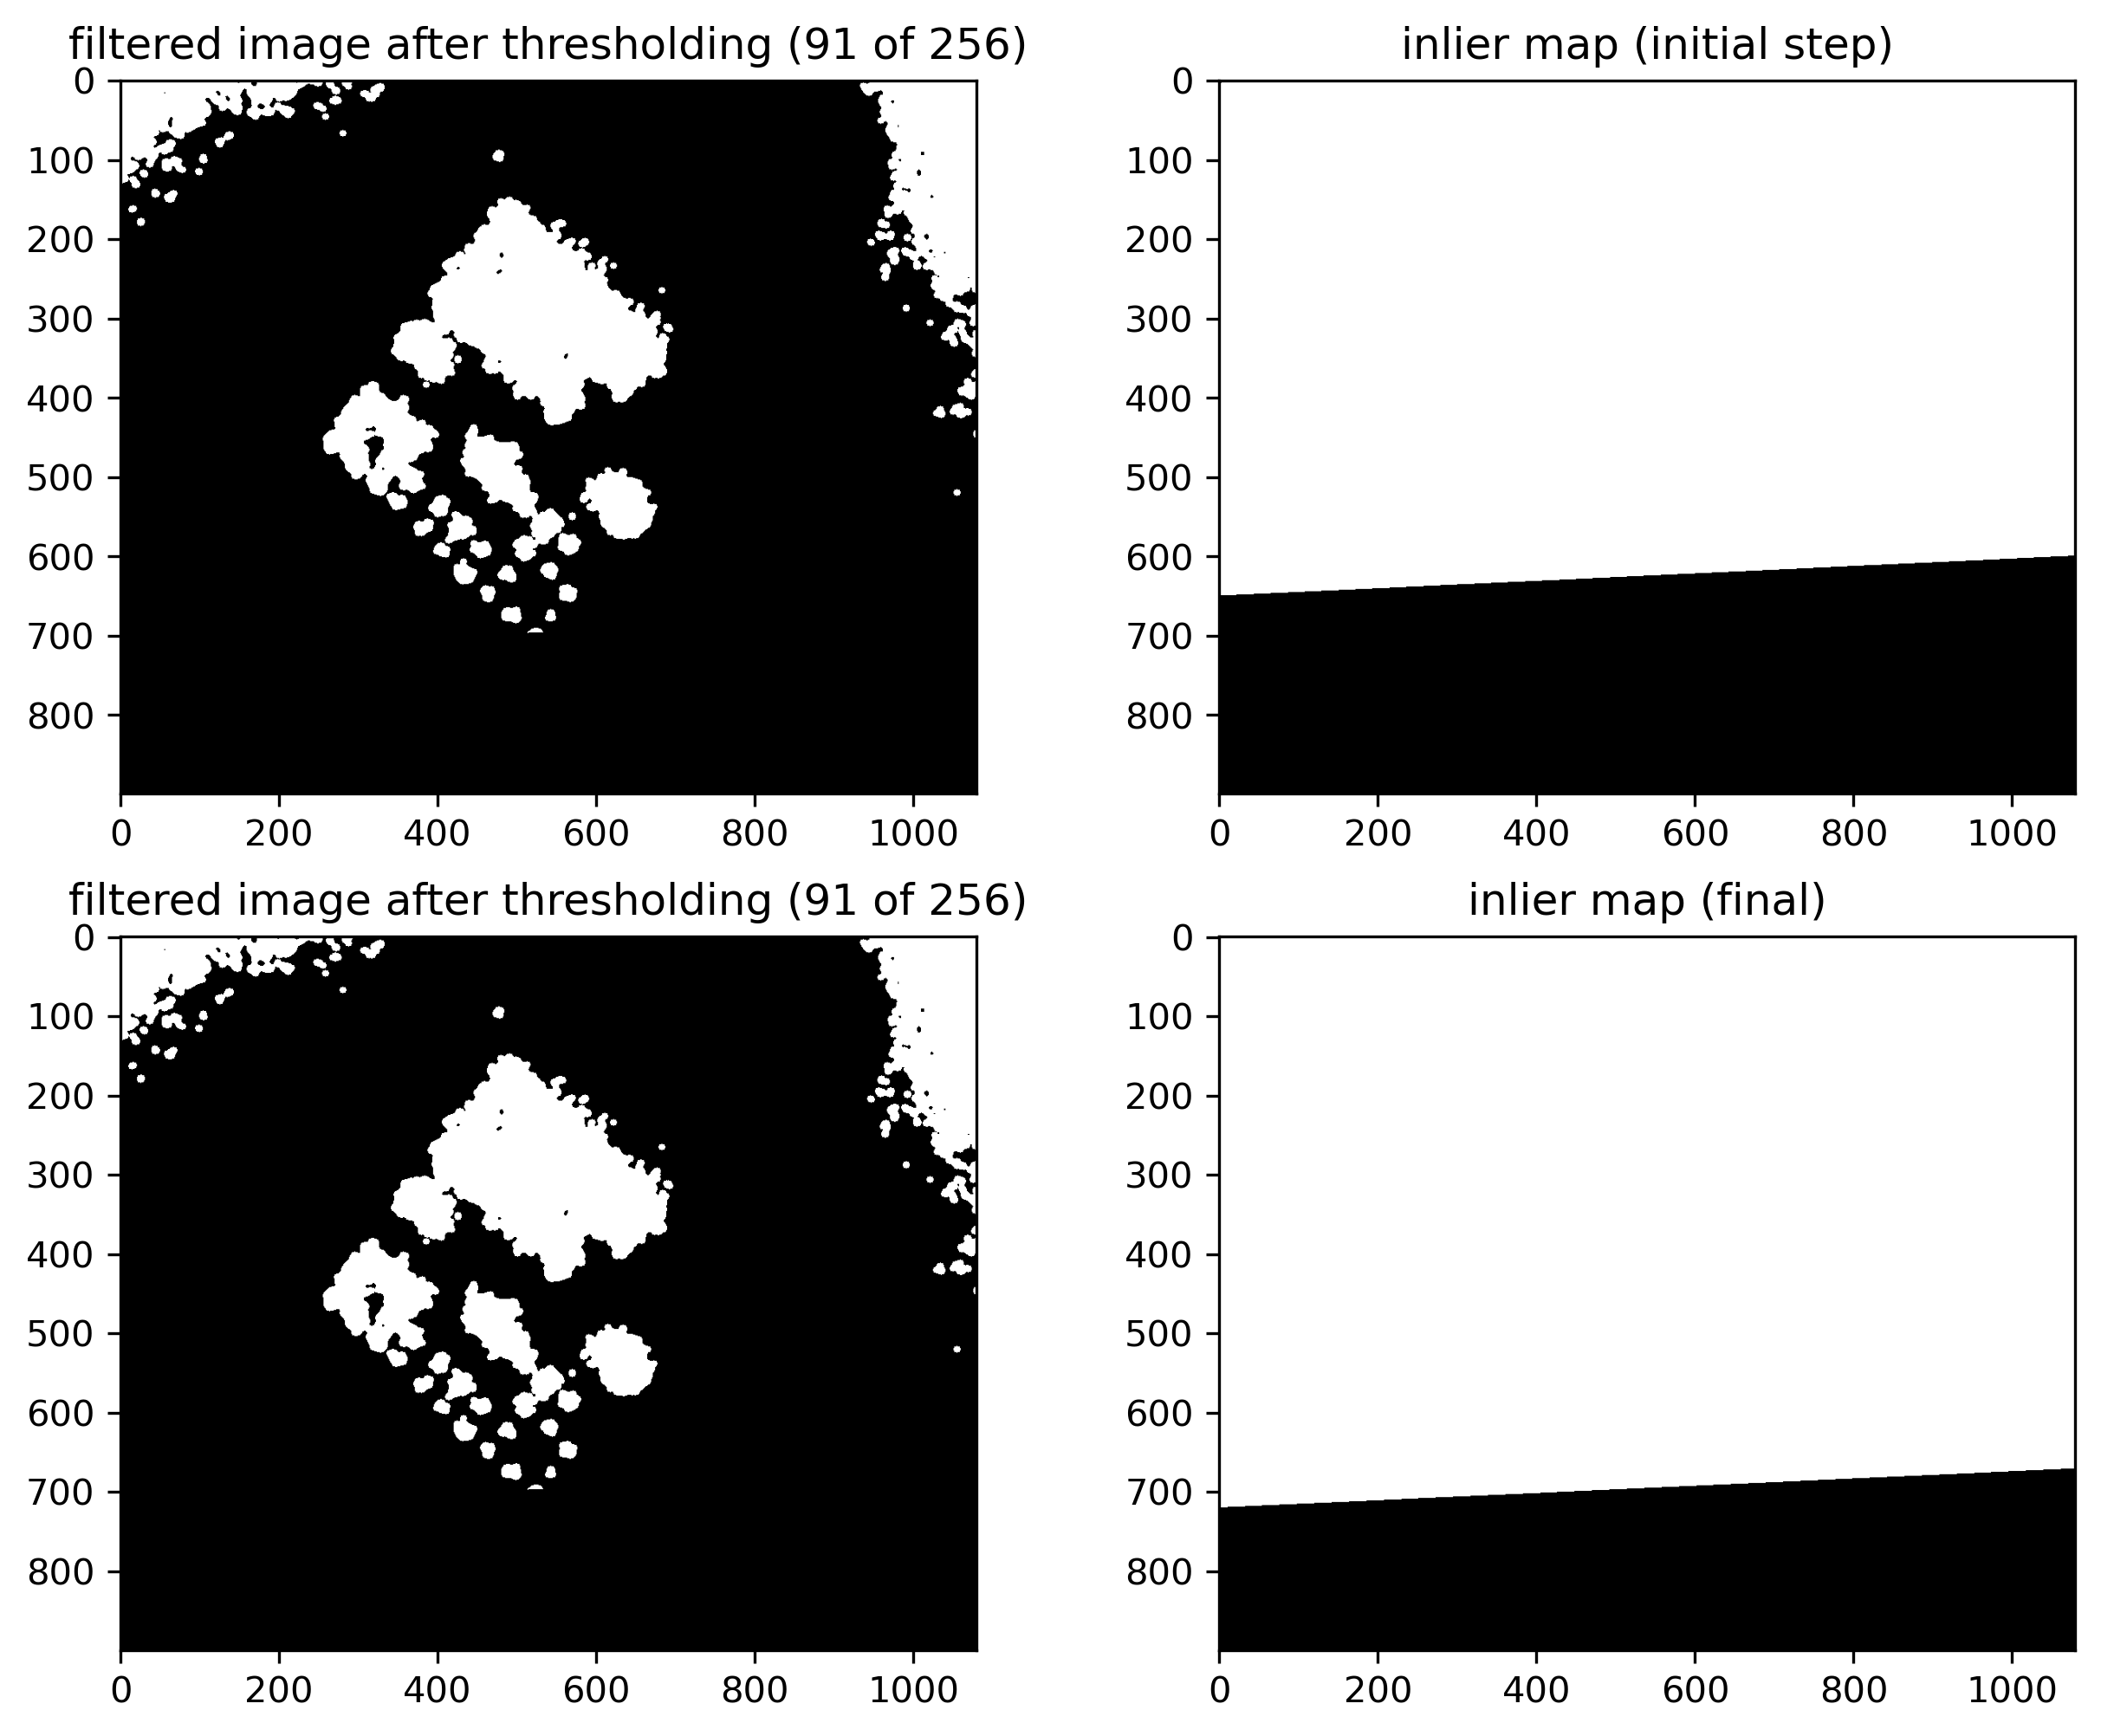

In [9]:
inlier_segmap1 = covariance_fitting(im_bin_f, 2)
inlier_segmap = covariance_fitting(im_bin_f*inlier_segmap1, 2.5)

fig = plt.figure(figsize=[10,8],dpi=300)
plt.subplot(221)
plt.imshow(im_bin_f, cmap='gray')
plt.title('filtered image after thresholding (%d of %d)' % (idx_threshold_f, MAXB))
plt.subplot(222)
plt.imshow(inlier_segmap1, cmap='gray')
plt.title('inlier map (initial step)')
plt.subplot(223)
plt.imshow(im_bin_f, cmap='gray')
plt.title('filtered image after thresholding (%d of %d)' % (idx_threshold_f, MAXB))
plt.subplot(224)
plt.imshow(inlier_segmap, cmap='gray')
plt.title('inlier map (final)')
plt.show()